In [1]:
import sys
sys.path.append('../')
import os
from time import time
import numpy as np
import torch
from torch import optim
from torch.autograd import Variable

# Random Forest Classification
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Tile2vec
from src.resnet import ResNet18
from src.tilenet import make_tilenet
from src.training import prep_triplets, train_triplet_epoch
from src.datasets import TileTripletsDataset, GetBands, RandomFlipAndRotate, ClipAndScale, ToFloatTensor, triplet_dataloader

import matplotlib.pyplot as plt
import matplotlib

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
tile2vec_dir = '../'
sys.path.append(tile2vec_dir)

# Environment stuff
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()
print(cuda)

# Dataloader + TileNet Setup

In [ ]:
# Defining Parameters
img_type = 'rgbm'
tiles_size = 50
tile_dir = '../data/sar/RS2-Flevoland/rgb-gray/triplets_' + str(tiles_size) + '/'
bands = 4
augment = False
batch_size = 100
shuffle = True
num_workers = 4
n_triplets = 10000 
# modification: adding 8700 more for semi-supervised learning purposes

In [9]:
dataloader = triplet_dataloader(img_type, tile_dir, bands=bands, augment=augment,
                                batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, 
                                n_triplets=n_triplets, pairs_only=True)
print('Dataloader set up complete.')

Dataloader set up complete.


In [11]:
in_channels = bands
z_dim = 512

TileNet = make_tilenet(in_channels=in_channels, z_dim=z_dim, strat2=False)
TileNet.train()
if cuda: TileNet.cuda()
print('TileNet set up complete.')

TileNet set up complete.


# Training Model + Writing Each Epoch to File

In [13]:
# Hyperparameter 
lr = 0.0003 # hyper tuned
optimizer = optim.Adam(TileNet.parameters(), lr=lr, betas=(0.9, 0.999)) # hyper tuned

epochs = 30
margin = 10
l2 = 0.01
print_every = 10000
save_models = True

model_dir = '../models/RS2-Flevoland/rgb-gray-nf_'+ str(tiles_size) + '/'
if not os.path.exists(model_dir): os.makedirs(model_dir)

In [15]:
t0 = time()
#with open(results_fn, 'w') as file:

plot_list = []
print('Begin training.................')
for epoch in range(0, epochs):
    (avg_loss, bullshit, avg_l_n, avg_l_d, avg_l_nd) = train_triplet_epoch(
        TileNet, cuda, dataloader, optimizer, epoch+1, margin=margin, l2=l2,
        print_every=print_every, t0=t0)
    plot_list.append((epoch+1,avg_loss))
    append_name = "strat1ht1_ep" + str(epoch+1) + ".ckpt"
    if save_models:
        model_fn = os.path.join(model_dir + append_name)
        torch.save(TileNet.state_dict(),model_fn)
        
np.save(os.path.join(model_dir + 'plot_list.npy', plot_list)    

Begin training.................
Epoch 1: [10000/10000 (100%)], Avg loss: 6.4939
Finished epoch 1: 389.503s
  Average loss: 6.4939
  Average l_n: 3.3697
  Average l_d: -11.5737
  Average l_nd: -8.2040

Epoch 2: [10000/10000 (100%)], Avg loss: 5.7088
Finished epoch 2: 436.000s
  Average loss: 5.7088
  Average l_n: 2.9956
  Average l_d: -11.3789
  Average l_nd: -8.3834

Epoch 3: [10000/10000 (100%)], Avg loss: 5.4008
Finished epoch 3: 482.534s
  Average loss: 5.4008
  Average l_n: 2.8377
  Average l_d: -11.4105
  Average l_nd: -8.5728

Epoch 4: [10000/10000 (100%)], Avg loss: 5.2284
Finished epoch 4: 529.326s
  Average loss: 5.2284
  Average l_n: 2.7327
  Average l_d: -11.3755
  Average l_nd: -8.6427

Epoch 5: [10000/10000 (100%)], Avg loss: 5.1612
Finished epoch 5: 576.043s
  Average loss: 5.1612
  Average l_n: 2.7468
  Average l_d: -11.4254
  Average l_nd: -8.6786

Epoch 6: [10000/10000 (100%)], Avg loss: 5.0759
Finished epoch 6: 622.825s
  Average loss: 5.0759
  Average l_n: 2.6941
  A

In [16]:
print(plot_list)

[(1, 6.493946852684021), (2, 5.70880820274353), (3, 5.40076455116272), (4, 5.228403244018555), (5, 5.1611570596694945), (6, 5.075880417823791), (7, 4.9973913669586185), (8, 4.97637640953064), (9, 4.953674430847168), (10, 4.914908804893494), (11, 4.885103316307068), (12, 4.787325139045715), (13, 4.804799208641052), (14, 4.703984780311584), (15, 4.730426626205444), (16, 4.684915134906769), (17, 4.722569403648376), (18, 4.603629732131958), (19, 4.6878531503677365), (20, 4.63700846195221), (21, 4.662391295433045), (22, 4.506323261260986), (23, 4.536091980934143), (24, 4.4849834990501405), (25, 4.593811175823212), (26, 4.497296917438507), (27, 4.471473197937012), (28, 4.508935334682465), (29, 4.616507894992829), (30, 4.452059946060181)]


# Pre Process Y Values

In [17]:
#note to self: need to embed tiles first and then figure out loop for reading in the saved model and plotting
#the classification accuracies per epoch
tile_dir = '../data/sar/RS2-Flevoland/rgb-gray/tiles_' + str(tiles_size) + '/'
n_tiles = 1000
y = np.load(os.path.join(tile_dir + 'y.npy')) 
print(y.shape)

le = LabelEncoder()
y = le.fit_transform(y)
print(set(y))

(1000,)


# Load in Epochs' Weights + Run each on tile embeddings + Random Forest 

In [22]:
def getTileEmbeddings(tilenet):
    X = np.zeros((n_tiles, z_dim))
    for idx in range(n_tiles):
        tile = np.load(os.path.join(tile_dir, '{}tile.npy'.format(idx+1)))
        # Get first 4 NAIP channels (5th is CDL mask)
        tile = tile[:,:,:4]
        # Rearrange to PyTorch order
        tile = np.moveaxis(tile, -1, 0)
        tile = np.expand_dims(tile, axis=0)
        # Scale to [0, 1]
        tile = tile / 255
        # Embed tile
        tile = torch.from_numpy(tile).float()
        tile = Variable(tile)
        if cuda: tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: z = z.cpu()
        z = z.data.numpy() #1 by 512
        X[idx,:] = z
    return X

In [23]:
epochsToAccuracy = []
epochsToSTD = []
for i in range(0,epochs): #iterator
    curEpoch = i + 1 # 9 + 1
    # Setting up model
    tilenet = ResNet18()
    if cuda: tilenet.cuda()
    model_fn = model_dir + "strat1ht1_ep"+str(curEpoch)+".ckpt" #open file
    #checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(torch.load(model_fn), strict=False)
    #tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    
    X = getTileEmbeddings(tilenet) #function above
    
    #train random forest classifier
    n_trials = 100
    accs = np.zeros((n_trials,))
    for i in range(n_trials):
        # Splitting data and training RF classifer
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_tr, y_tr) #X-tr is 512 by 1
        accs[i] = rf.score(X_te, y_te)
    print("Results for Epoch Number: ", str(curEpoch))
    print('Mean accuracy: {:0.4f}'.format(accs.mean()))
    print('Standard deviation: {:0.4f}'.format(accs.std()))
    epochsToAccuracy.append((curEpoch,accs.mean()))
    epochsToSTD.append((curEpoch,accs.std()))
#     break
    
# save value   
np.save(os.path.join(model_dir + 'epochsToAccuracy.npy', epochsToAccuracy)  
np.save(os.path.join(model_dir + 'epochsToSTD.npy', epochsToSTD)     
    

Results for Epoch Number:  1
Mean accuracy: 0.6288
Standard deviation: 0.0344
Results for Epoch Number:  2
Mean accuracy: 0.6432
Standard deviation: 0.0283
Results for Epoch Number:  3
Mean accuracy: 0.6450
Standard deviation: 0.0323
Results for Epoch Number:  4
Mean accuracy: 0.6436
Standard deviation: 0.0307
Results for Epoch Number:  5
Mean accuracy: 0.6653
Standard deviation: 0.0298
Results for Epoch Number:  6
Mean accuracy: 0.6594
Standard deviation: 0.0345
Results for Epoch Number:  7
Mean accuracy: 0.6636
Standard deviation: 0.0286
Results for Epoch Number:  8
Mean accuracy: 0.6569
Standard deviation: 0.0309
Results for Epoch Number:  9
Mean accuracy: 0.6664
Standard deviation: 0.0294
Results for Epoch Number:  10
Mean accuracy: 0.6630
Standard deviation: 0.0306
Results for Epoch Number:  11
Mean accuracy: 0.6677
Standard deviation: 0.0318
Results for Epoch Number:  12
Mean accuracy: 0.6714
Standard deviation: 0.0339
Results for Epoch Number:  13
Mean accuracy: 0.6664
Standard 

In [24]:
print(epochsToSTD)

[(1, 0.034424700434426456), (2, 0.028296422035303335), (3, 0.03225286808952036), (4, 0.030725233929133892), (5, 0.029839738604753217), (6, 0.034462153153858505), (7, 0.02862948654796309), (8, 0.0308608165802527), (9, 0.029438877356312346), (10, 0.03062756111739881), (11, 0.03176771159526603), (12, 0.03389749253263432), (13, 0.03190497610091566), (14, 0.02604323328621082), (15, 0.030103986446980726), (16, 0.030463748948545373), (17, 0.028092481200492053), (18, 0.0342144340885539), (19, 0.03113454672867424), (20, 0.03028510359896428), (21, 0.030402467005162574), (22, 0.030205297548608904), (23, 0.029348381556740043), (24, 0.028933501343598206), (25, 0.026909988851725655), (26, 0.027918586998628713), (27, 0.0283400776286869), (28, 0.03009464238033074), (29, 0.029653456796805314), (30, 0.030328658064609437)]


In [25]:
plt.plot(*zip(*epochsToAccuracy))
plt.title('Triplet Augmentation Average Test Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(epochsToAccuracy[epochs-1][1], "was the final Accuracy")

<Figure size 640x480 with 1 Axes>

0.6843499999999999 was the final Accuracy


The min loss was 4.452059946060181


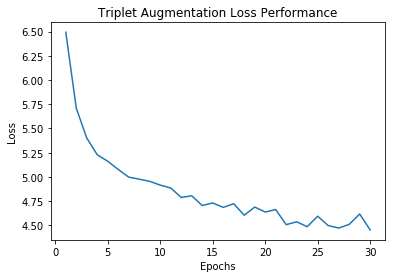

In [26]:
plt.plot(*zip(*plot_list))
plt.title('Triplet Augmentation Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print("The min loss was",str(plot_list[epochs-1][1]))
plt.show()

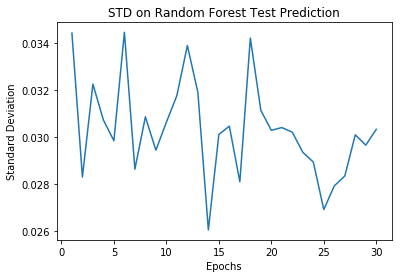

In [27]:
plt.plot(*zip(*epochsToSTD))
plt.title('STD on Random Forest Test Prediction')
plt.xlabel('Epochs')
plt.ylabel('Standard Deviation')
plt.show()

# Code for Visualizations/Analysis

In [28]:
#iterator
i = 29
curEpoch = epochs
# Setting up model
tilenet = ResNet18()
if cuda: tilenet.cuda()
model_fn = model_dir + "strat1ht1_ep"+str(curEpoch)+".ckpt" # open file
tilenet.load_state_dict(torch.load(model_fn), strict=False)
tilenet.eval()

X = getTileEmbeddings(tilenet) #function above

#train random forest classifier
n_trials = 100
accs = np.zeros((n_trials,))
#for i in range(n_trials):
    # Splitting data and training RF classifer
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_tr, y_tr) #X-tr is 512 by 1
rf_predictions = rf.predict(X_te)
print(rf_predictions.shape)
rf_probs = rf.predict_proba(X_te)[:, 1]
print(rf_probs.shape)

# from sklearn.metrics import roc_auc_score
# roc_value = roc_auc_score(y_te, rf_probs)
# print(roc_value)

#accs[i] = rf.score(X_te, y_te)
# print("Results for Epoch Number: ", str(curEpoch))
# print('Mean accuracy: {:0.4f}'.format(accs.mean()))
# print('Standard deviation: {:0.4f}'.format(accs.std()))
# epochsToAccuracy.append((curEpoch,accs.mean()))
# epochsToSTD.append((curEpoch,accs.std()))
# print(epochsToAccuracy)
# print(epochsToSTD)

(200,)
(200,)


In [29]:
print(y_te.shape)

(200,)


In [30]:
#classes
print(rf_predictions)
print(list(set(y)))

[12  9  9 20  9 12  9 20  9  9  9  9 20  5  9 20  9 17  9  9  9  9 12 20
 17 16  8 20  8  9 16  9  9 20  9  9  9  9  9 12 17 20 20 20  8  9  9  9
 12 12  9 20  9  9  9  9 20 17 12 12  9 20 12 20 13 17  9  9 17  9 16  9
 12  9  9  9 17 12  9 16  9  7 12  9  9 12  9  9 20  9  9 16 16  9 20  9
  9 12  9 22  9  9 17 12 12  9 12 20  9 17 12 13 20 12  9  9  5 20 20 17
 20 17  5 20  9  9  9 17  9  9 20 17  9  9  9  9  9 12 12  8 12 24  9 12
  9 18 20 20  9  9  9 17  9 12  9  8  9  9 20  9 16 12  5  5 12  9  9 20
  9 17 12 20 12 12  9 12 20  9 20 20 16  9 20  9  1 17  9  9  9 20  9 12
 12 17 12  9  9 20 20  9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [31]:

from sklearn.metrics import confusion_matrix

y_true = y_te
y_pred = rf_predictions
classes = list(set(y))

confused= confusion_matrix(y_true, y_pred, labels=classes)
A = confused
print(confused.shape)
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in A]))

cm = confused
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print(recall)
print(precision)
print(np.mean(recall))
rnum = 0.0
rd = 0
import math
for i in recall:
    if not math.isnan(i) and i > 0:
        rd +=1
        rnum += i
print(rnum/rd)
pn = 0.0
pd = 0
for i in precision:
    if not math.isnan(i) and i > 0:
        pn += i
        pd += 1
print(pn/pd)

print(np.mean(precision))



(28, 28)
   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   4   0   0   0   1   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   2   5   0   0   0   0   0   0   0   0   0   0   2   

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [32]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=7,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(100,100),dpi=100)
    #plt.figure()
    #plt.tight_layout()

Confusion matrix, without normalization


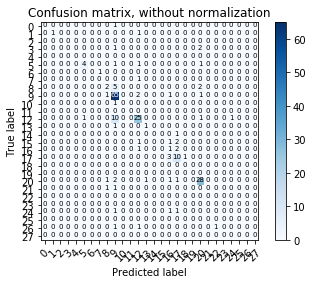

<Figure size 10000x10000 with 0 Axes>

In [33]:
cnf_matrix = confused
np.set_printoptions(precision=2)
import itertools

# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')